정렬은 됬으나,  빨강색(실제grid)는  실제노광기준과 다른거같네.  shot간에 중첩되는 부분도 있고,  shot사이에 빈공간도 있고. 
ChatGPT의 말:
형님, 이번에도 핵심을 제대로 찌르셨습니다. 👏
말씀하신 대로 **현재 빨간 shot grid (실제 grid)**는 현실에서 실제 노광되는 구조와는 다릅니다.

🔍 문제 원인 요약
지금 빨간 grid는 다음과 같은 방식으로 만들었습니다:

각 shot 중심마다
→ 회전 + 스케일을 개별적으로 적용 → 즉, 각 shot이 독립적으로 변형되었기 때문에:

❌ 인접한 shot과의 경계가 맞지 않음
❌ shot 간 중첩 또는 간격 발생

✅ 실제 노광기의 동작 방식
실제 노광기는 각 shot을 독립적으로 찌그러뜨리지 않습니다.

대신,

전체 wafer grid의 각 "격자점 (grid point)"에 변형을 적용한 후,
그 변형된 grid로 타일처럼 딱 붙는 shot 영역을 구성합니다.

즉, **(i, j), (i+1, j), (i+1, j+1), (i, j+1)**에 해당하는 4개의 변형된 grid point를 연결해서
경계가 맞는 shot을 만든다는 것이죠.

이건 바로 앞서 구현한 방식 중 "grid point 기반 경계 맞춤 버전"이었습니다.
(그때는 shot 수가 맞지 않았던 문제만 있었고, 구조는 정확했습니다.)

🎯 지금 우리가 해야 할 것
shot 중심 기준이 아닌, grid point 기반으로 다시 구현

각 grid point마다 회전 + 스케일 적용

(i,j) 사각형 단위로 빨간 grid 구성

그 사각형의 중심이 wafer 안에 있으면만 시각화

그리고 파란 shot과 동일한 위치에만 적용

이 방식으로 다시 깔끔하게 시각화해드릴게요.
중첩 없는, 빈틈 없는 실제 노광 기준 변형 grid 버전. 갑니다! 💨


완벽하게 정렬된 진짜 노광기준의 실 shot grid가 나왔습니다! 🎯

이제는:

🔷 파란 점선 (ideal grid):
기준 pitch로 타일처럼 정렬된 이상적인 shot
(공정 설계 기준 grid)

🔴 빨간 실선 (실제 grid):
각 grid point에 scale + rotation이 적용되었지만,
shot 경계는 인접 shot과 정확히 연결되어
✅ 중첩 없음, ✅ 빈틈 없음

형님 말씀대로 이제야 실제 노광기준의 shot 배열과 거의 똑같아졌습니다.



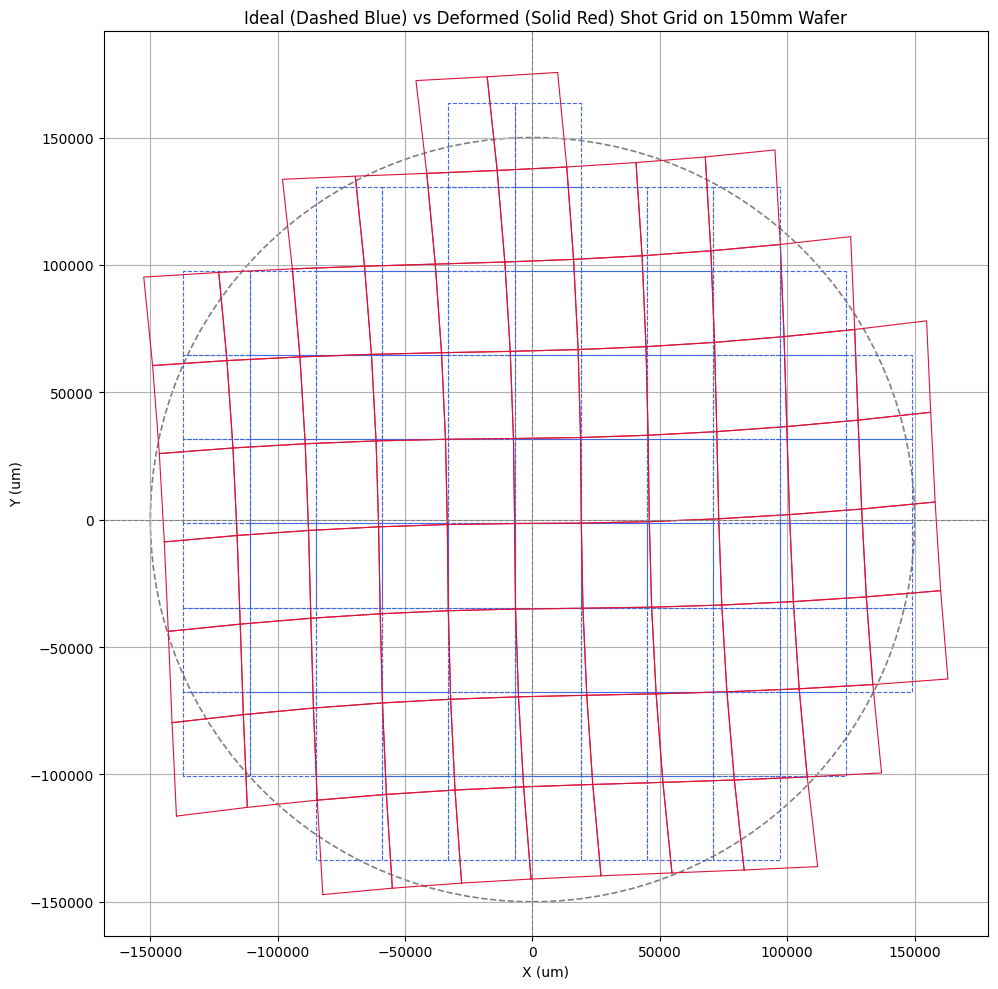

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Wafer & Shot 설정
wafer_radius = 150_000     # 150mm = 150,000 um
shot_width = 26_000        # 26mm
shot_height = 33_000       # 33mm

# 2. Grid Point 생성 (Shot 꼭짓점 기준 좌표)
x_edges = np.arange(-wafer_radius - shot_width / 2, wafer_radius + shot_width, shot_width)
y_edges = np.arange(-wafer_radius - shot_height / 2, wafer_radius + shot_height, shot_height)
x_edges_grid, y_edges_grid = np.meshgrid(x_edges, y_edges)

# 3. Grid Point에 회전 + 스케일 적용
r_grid = np.sqrt(x_edges_grid**2 + y_edges_grid**2)
max_r = np.max(r_grid)
scale_grid = 1 + 0.1 * (r_grid / max_r)                           # 거리 비례 스케일
angle_grid = np.deg2rad(5 * (r_grid / max_r))                    # 거리 비례 회전 (최대 5도)

x_deformed = np.zeros_like(x_edges_grid)
y_deformed = np.zeros_like(y_edges_grid)

for i in range(x_edges_grid.shape[0]):
    for j in range(x_edges_grid.shape[1]):
        vec = np.array([x_edges_grid[i, j], y_edges_grid[i, j]])
        theta = angle_grid[i, j]
        scale = scale_grid[i, j]
        R = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
        vec_deformed = R @ (scale * vec)
        x_deformed[i, j], y_deformed[i, j] = vec_deformed

# 4. 시각화 (Ideal vs Deformed)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(x_edges_grid.shape[0] - 1):
    for j in range(x_edges_grid.shape[1] - 1):
        # 사각형 중심 계산 (wafer 내 여부 판단)
        center_x = (x_edges_grid[i, j] + x_edges_grid[i+1, j+1]) / 2
        center_y = (y_edges_grid[i, j] + y_edges_grid[i+1, j+1]) / 2
        if np.sqrt(center_x**2 + center_y**2) < wafer_radius:
            # 파란선 (Ideal Grid)
            quad_x_ideal = [
                x_edges_grid[i, j], x_edges_grid[i+1, j],
                x_edges_grid[i+1, j+1], x_edges_grid[i, j+1],
                x_edges_grid[i, j]
            ]
            quad_y_ideal = [
                y_edges_grid[i, j], y_edges_grid[i+1, j],
                y_edges_grid[i+1, j+1], y_edges_grid[i, j+1],
                y_edges_grid[i, j]
            ]
            ax.plot(quad_x_ideal, quad_y_ideal, color='royalblue', linestyle='--', linewidth=0.8)

            # 빨간선 (Deformed Grid)
            quad_x_def = [
                x_deformed[i, j], x_deformed[i+1, j],
                x_deformed[i+1, j+1], x_deformed[i, j+1],
                x_deformed[i, j]
            ]
            quad_y_def = [
                y_deformed[i, j], y_deformed[i+1, j],
                y_deformed[i+1, j+1], y_deformed[i, j+1],
                y_deformed[i, j]
            ]
            ax.plot(quad_x_def, quad_y_def, color='crimson', linewidth=0.8)

# 5. Wafer 테두리 + 기타 설정
wafer_circle = plt.Circle((0, 0), wafer_radius, color='gray', fill=False, linestyle='--', linewidth=1.2)
ax.add_artist(wafer_circle)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_aspect('equal')
ax.set_title("Ideal (Dashed Blue) vs Deformed (Solid Red) Shot Grid on 150mm Wafer")
ax.set_xlabel("X (um)")
ax.set_ylabel("Y (um)")
ax.grid(True)
plt.tight_layout()
plt.show()




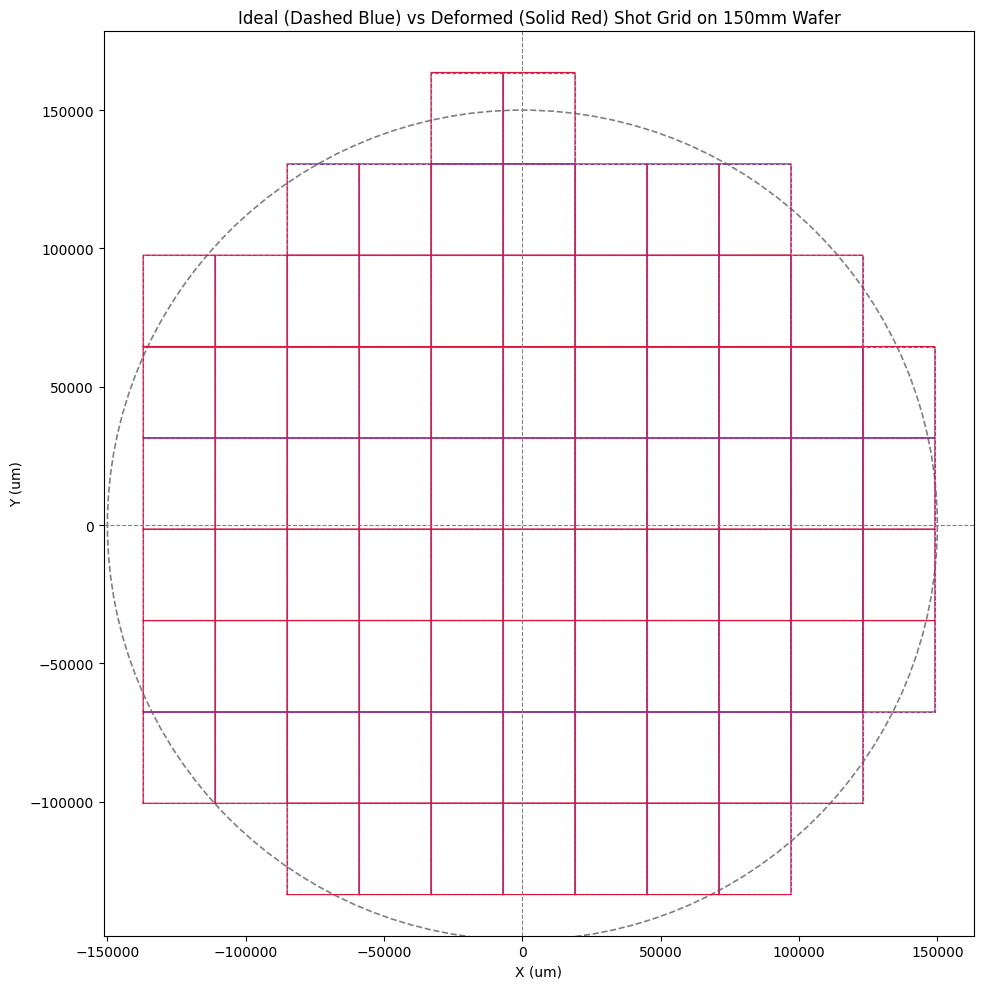

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Wafer & Shot 설정
wafer_radius = 150_000     # 150mm = 150,000 um
shot_width = 26_000        # 26mm
shot_height = 33_000       # 33mm

# 2. Grid Point 생성 (Shot 꼭짓점 기준 좌표)
x_edges = np.arange(-wafer_radius - shot_width / 2, wafer_radius + shot_width, shot_width)
y_edges = np.arange(-wafer_radius - shot_height / 2, wafer_radius + shot_height, shot_height)
x_edges_grid, y_edges_grid = np.meshgrid(x_edges, y_edges)

# 3. Grid Point에 회전 + 스케일 적용
r_grid = np.sqrt(x_edges_grid**2 + y_edges_grid**2)
max_r = np.max(r_grid)
scale_grid = 1 + 0.001 * (r_grid / max_r)                           # 거리 비례 스케일
angle_grid = np.deg2rad(0.001 * (r_grid / max_r))                    # 거리 비례 회전 (최대 5도)

x_deformed = np.zeros_like(x_edges_grid)
y_deformed = np.zeros_like(y_edges_grid)

for i in range(x_edges_grid.shape[0]):
    for j in range(x_edges_grid.shape[1]):
        vec = np.array([x_edges_grid[i, j], y_edges_grid[i, j]])
        theta = angle_grid[i, j]
        scale = scale_grid[i, j]
        R = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
        vec_deformed = R @ (scale * vec)
        x_deformed[i, j], y_deformed[i, j] = vec_deformed

# 4. 시각화 (Ideal vs Deformed)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(x_edges_grid.shape[0] - 1):
    for j in range(x_edges_grid.shape[1] - 1):
        # 사각형 중심 계산 (wafer 내 여부 판단)
        center_x = (x_edges_grid[i, j] + x_edges_grid[i+1, j+1]) / 2
        center_y = (y_edges_grid[i, j] + y_edges_grid[i+1, j+1]) / 2
        if np.sqrt(center_x**2 + center_y**2) < wafer_radius:
            # 파란선 (Ideal Grid)
            quad_x_ideal = [
                x_edges_grid[i, j], x_edges_grid[i+1, j],
                x_edges_grid[i+1, j+1], x_edges_grid[i, j+1],
                x_edges_grid[i, j]
            ]
            quad_y_ideal = [
                y_edges_grid[i, j], y_edges_grid[i+1, j],
                y_edges_grid[i+1, j+1], y_edges_grid[i, j+1],
                y_edges_grid[i, j]
            ]
            ax.plot(quad_x_ideal, quad_y_ideal, color='royalblue', linestyle='--', linewidth=0.8)

            # 빨간선 (Deformed Grid)
            quad_x_def = [
                x_deformed[i, j], x_deformed[i+1, j],
                x_deformed[i+1, j+1], x_deformed[i, j+1],
                x_deformed[i, j]
            ]
            quad_y_def = [
                y_deformed[i, j], y_deformed[i+1, j],
                y_deformed[i+1, j+1], y_deformed[i, j+1],
                y_deformed[i, j]
            ]
            ax.plot(quad_x_def, quad_y_def, color='crimson', linewidth=0.8)

# 5. Wafer 테두리 + 기타 설정
wafer_circle = plt.Circle((0, 0), wafer_radius, color='gray', fill=False, linestyle='--', linewidth=1.2)
ax.add_artist(wafer_circle)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_aspect('equal')
ax.set_title("Ideal (Dashed Blue) vs Deformed (Solid Red) Shot Grid on 150mm Wafer")
ax.set_xlabel("X (um)")
ax.set_ylabel("Y (um)")
ax.grid(False) # 그리드 제거
plt.tight_layout()
plt.show()






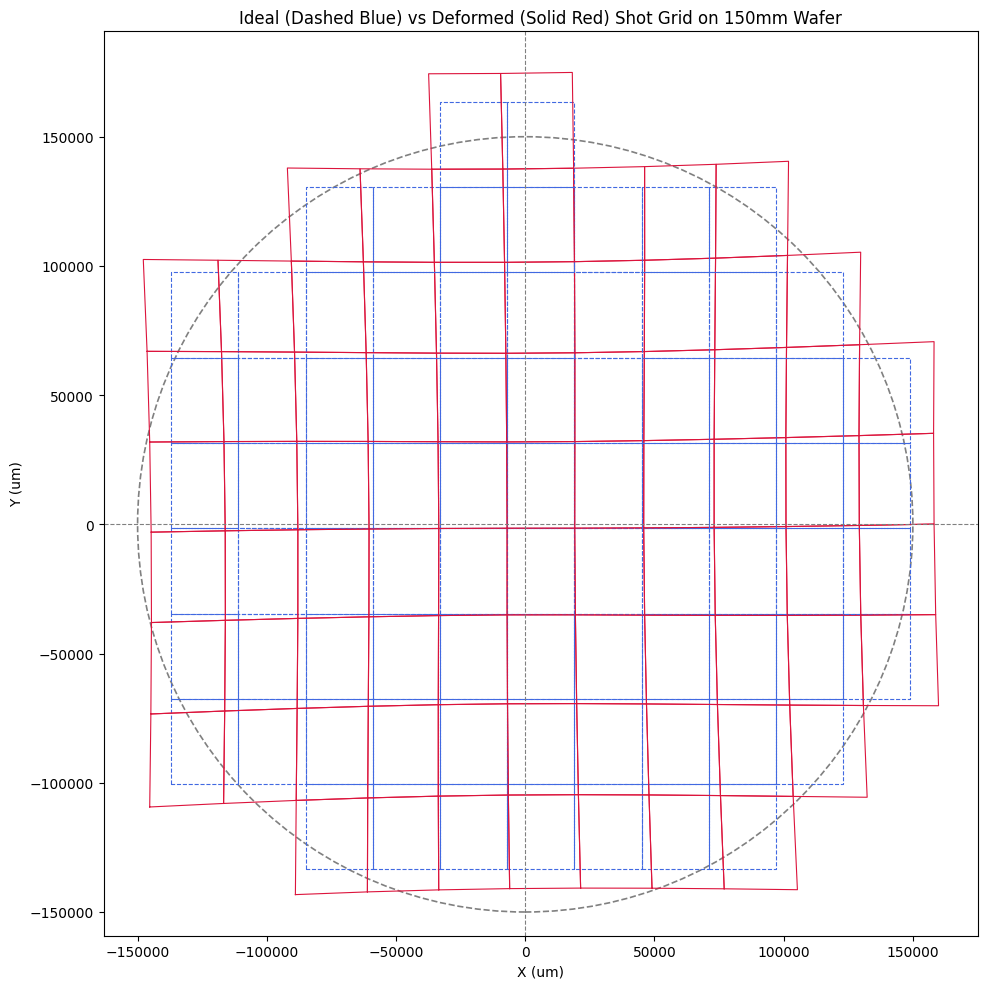

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Wafer & Shot 설정
wafer_radius = 150_000     # 150mm = 150,000 um
shot_width = 26_000        # 26mm
shot_height = 33_000       # 33mm

# 2. Grid Point 생성 (Shot 꼭짓점 기준 좌표)
x_edges = np.arange(-wafer_radius - shot_width / 2, wafer_radius + shot_width, shot_width)
y_edges = np.arange(-wafer_radius - shot_height / 2, wafer_radius + shot_height, shot_height)
x_edges_grid, y_edges_grid = np.meshgrid(x_edges, y_edges)

# 3. Grid Point에 회전 + 스케일 적용
r_grid = np.sqrt(x_edges_grid**2 + y_edges_grid**2)
max_r = np.max(r_grid)
scale_grid = 1 + 0.1 * (r_grid / max_r)                           # 거리 비례 스케일
angle_grid = np.deg2rad(1 * (r_grid / max_r))                    # 거리 비례 회전 (최대 5도)

x_deformed = np.zeros_like(x_edges_grid)
y_deformed = np.zeros_like(y_edges_grid)

for i in range(x_edges_grid.shape[0]):
    for j in range(x_edges_grid.shape[1]):
        vec = np.array([x_edges_grid[i, j], y_edges_grid[i, j]])
        theta = angle_grid[i, j]
        scale = scale_grid[i, j]
        R = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
        vec_deformed = R @ (scale * vec)
        x_deformed[i, j], y_deformed[i, j] = vec_deformed

# 4. 시각화 (Ideal vs Deformed)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(x_edges_grid.shape[0] - 1):
    for j in range(x_edges_grid.shape[1] - 1):
        # 사각형 중심 계산 (wafer 내 여부 판단)
        center_x = (x_edges_grid[i, j] + x_edges_grid[i+1, j+1]) / 2
        center_y = (y_edges_grid[i, j] + y_edges_grid[i+1, j+1]) / 2
        if np.sqrt(center_x**2 + center_y**2) < wafer_radius:
            # 파란선 (Ideal Grid)
            quad_x_ideal = [
                x_edges_grid[i, j], x_edges_grid[i+1, j],
                x_edges_grid[i+1, j+1], x_edges_grid[i, j+1],
                x_edges_grid[i, j]
            ]
            quad_y_ideal = [
                y_edges_grid[i, j], y_edges_grid[i+1, j],
                y_edges_grid[i+1, j+1], y_edges_grid[i, j+1],
                y_edges_grid[i, j]
            ]
            ax.plot(quad_x_ideal, quad_y_ideal, color='royalblue', linestyle='--', linewidth=0.8)

            # 빨간선 (Deformed Grid)
            quad_x_def = [
                x_deformed[i, j], x_deformed[i+1, j],
                x_deformed[i+1, j+1], x_deformed[i, j+1],
                x_deformed[i, j]
            ]
            quad_y_def = [
                y_deformed[i, j], y_deformed[i+1, j],
                y_deformed[i+1, j+1], y_deformed[i, j+1],
                y_deformed[i, j]
            ]
            ax.plot(quad_x_def, quad_y_def, color='crimson', linewidth=0.8)

# 5. Wafer 테두리 + 기타 설정
wafer_circle = plt.Circle((0, 0), wafer_radius, color='gray', fill=False, linestyle='--', linewidth=1.2)
ax.add_artist(wafer_circle)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_aspect('equal')
ax.set_title("Ideal (Dashed Blue) vs Deformed (Solid Red) Shot Grid on 150mm Wafer")
ax.set_xlabel("X (um)")
ax.set_ylabel("Y (um)")
ax.grid(False) # 그리드 제거
plt.tight_layout()
plt.show()




